<center>
    <h1>Fruit Inspection - Second Task: Russet Detection</h1>
    <h2>Image Processing and Computer Vision</h2>
    <h3>Facundo Nicolas Maidana and Riccardo Spolaor</h3>
    <h4>facundo.maidana@studio.unibo.it; riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This notebook presents the development of a system aimed at locating defects and imperfection in fruits. Each fruit is acquired through a NIR *(Near Infra-Red)* and color camera that present little parallax effect among each other.

<table>
    <tr>
        <td><img src="images/second task/C0_000004.png" width="200"/></td>
        <td><img src="images/second task/C1_000004.png" width="200"/></td>
    </tr>
    <tr>
        <td style='text-align:left'>NIR example</td>
        <td style='text-align:left'>Color example</td>
    </tr>
</table>

# 00 Prerequisites
The libraries necessary for the task are imported.

In [1]:
#!pip install scikit-learn 

In [2]:
%matplotlib inline

import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from time import process_time, time

# Utils libraries
from graphics import *
from utils import *

The cell below illustrates the version of `OpenCV` used for the task.

In [3]:
print(f'Using OpenCV version: {cv2.__version__}.')

Using OpenCV version: 4.6.0.


The random seed is set for both the `numpy` and `OpenCV` libraries in order to guarantee reproducibility of results.

In [4]:
SEED = 42

cv2.setRNGSeed(SEED)
np.random.seed(SEED)

# 01 Image analysis 
The series of images is firstly imported and plotted.

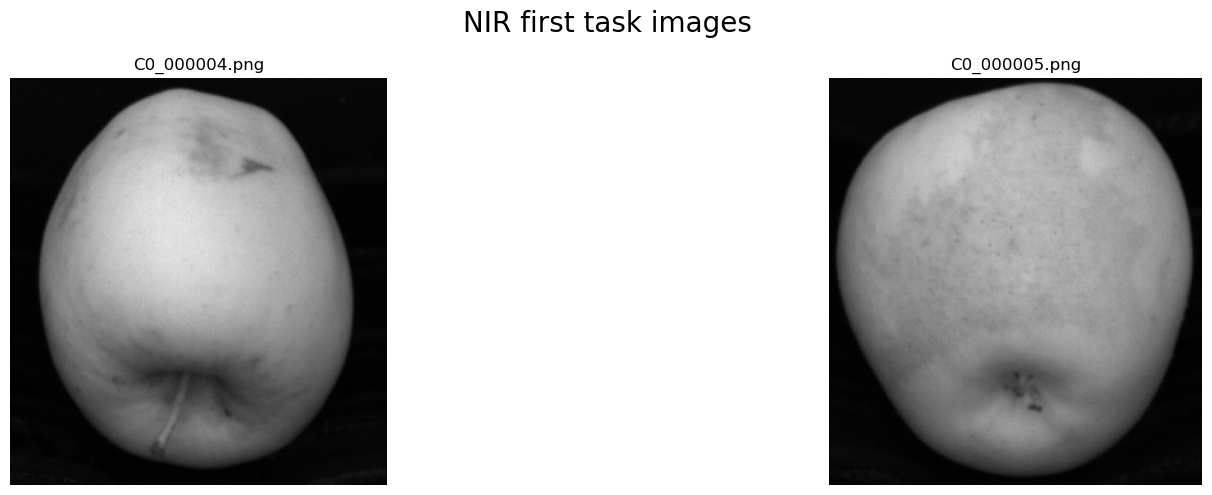

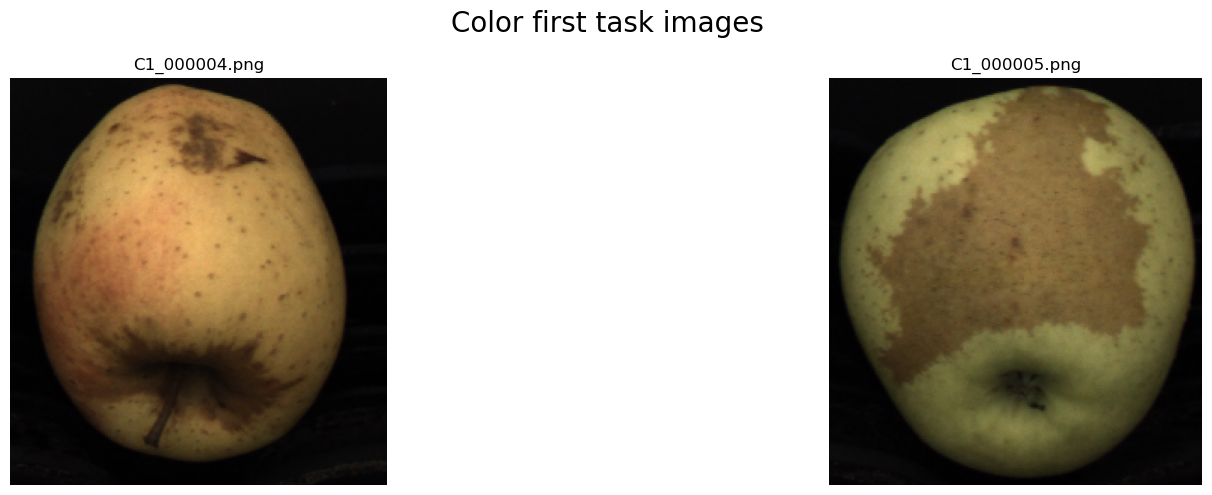

In [5]:
# Create two arrays containing the names of the NIR and color images respectively
nir_names, colour_names = [[f'C{j}_00000{i}.png' for i in [4, 5]] for j in [0,1]]

# Directory where the images are saved
DIR = 'images/second task/'

# Import NIR and colour images
nir_imgs = [cv2.imread(f'{DIR}{img}', cv2.IMREAD_GRAYSCALE) for img in nir_names]
colour_imgs = [cv2.imread(f'{DIR}{img}') for img in colour_names]

# Plot the NIR and color images
plot_image_grid(nir_imgs, 'NIR first task images', nir_names)
plot_image_grid(colour_imgs, 'Color first task images', colour_names)

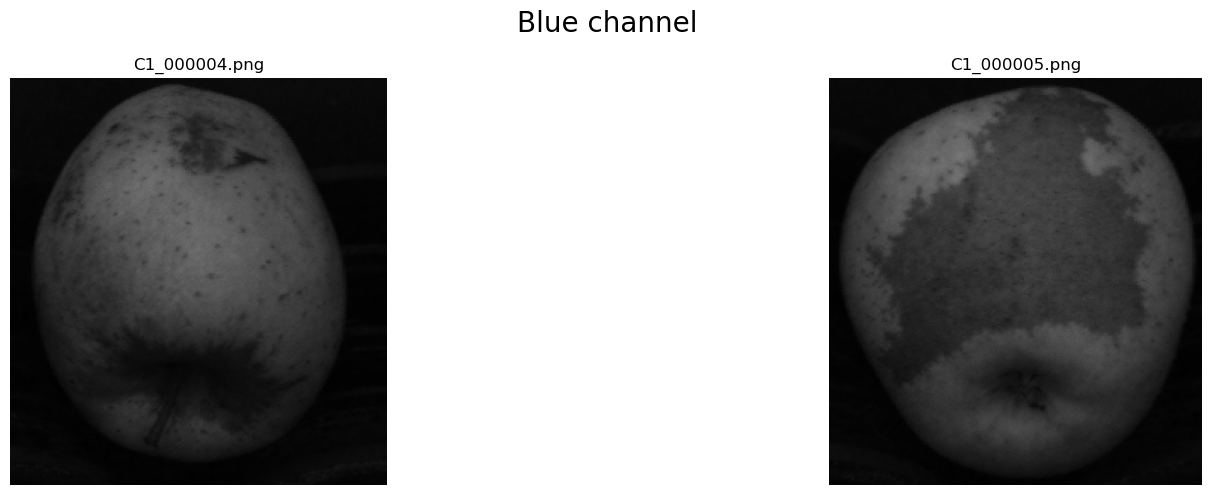

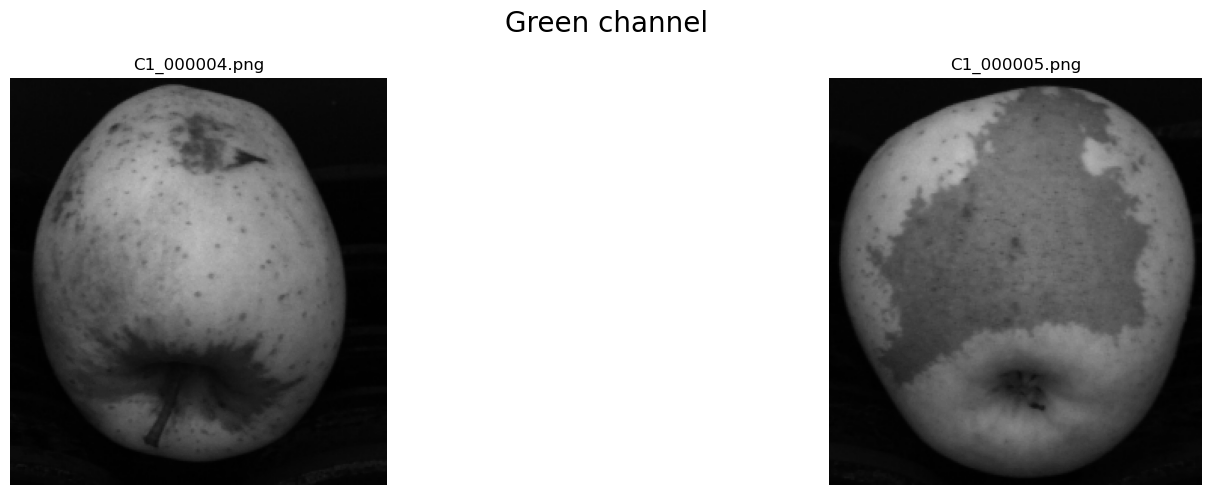

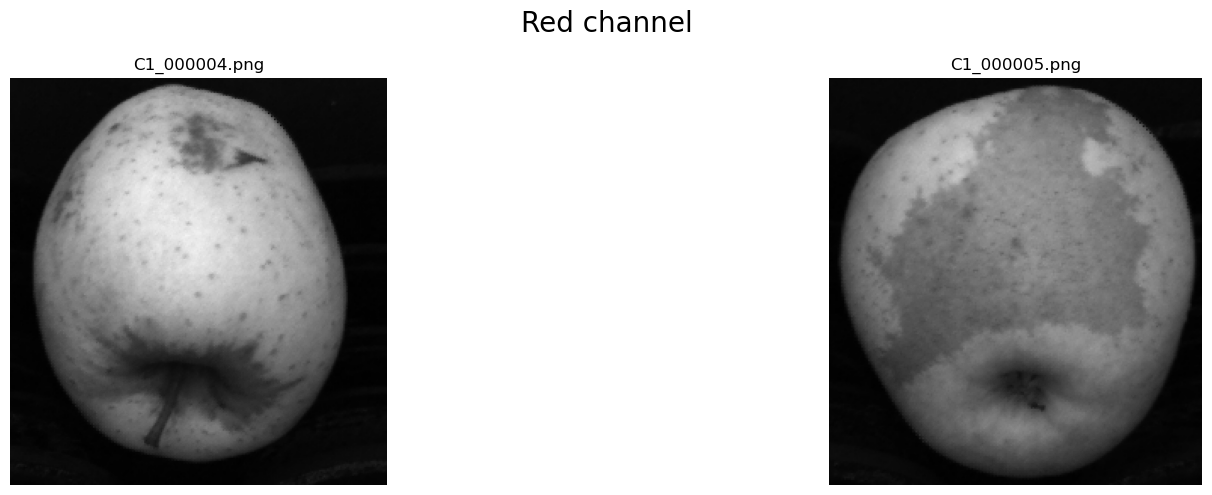

In [6]:
colour_B = []; colour_G = []; colour_R = []

for img in colour_imgs:
    B, G, R = cv2.split(img)
    colour_B.append(B)
    colour_G.append(G)
    colour_R.append(R)

# Plot the Channels of the images
plot_image_grid(colour_B, 'Blue channel', colour_names)
plot_image_grid(colour_G, 'Green channel', colour_names)
plot_image_grid(colour_R, 'Red channel', colour_names)

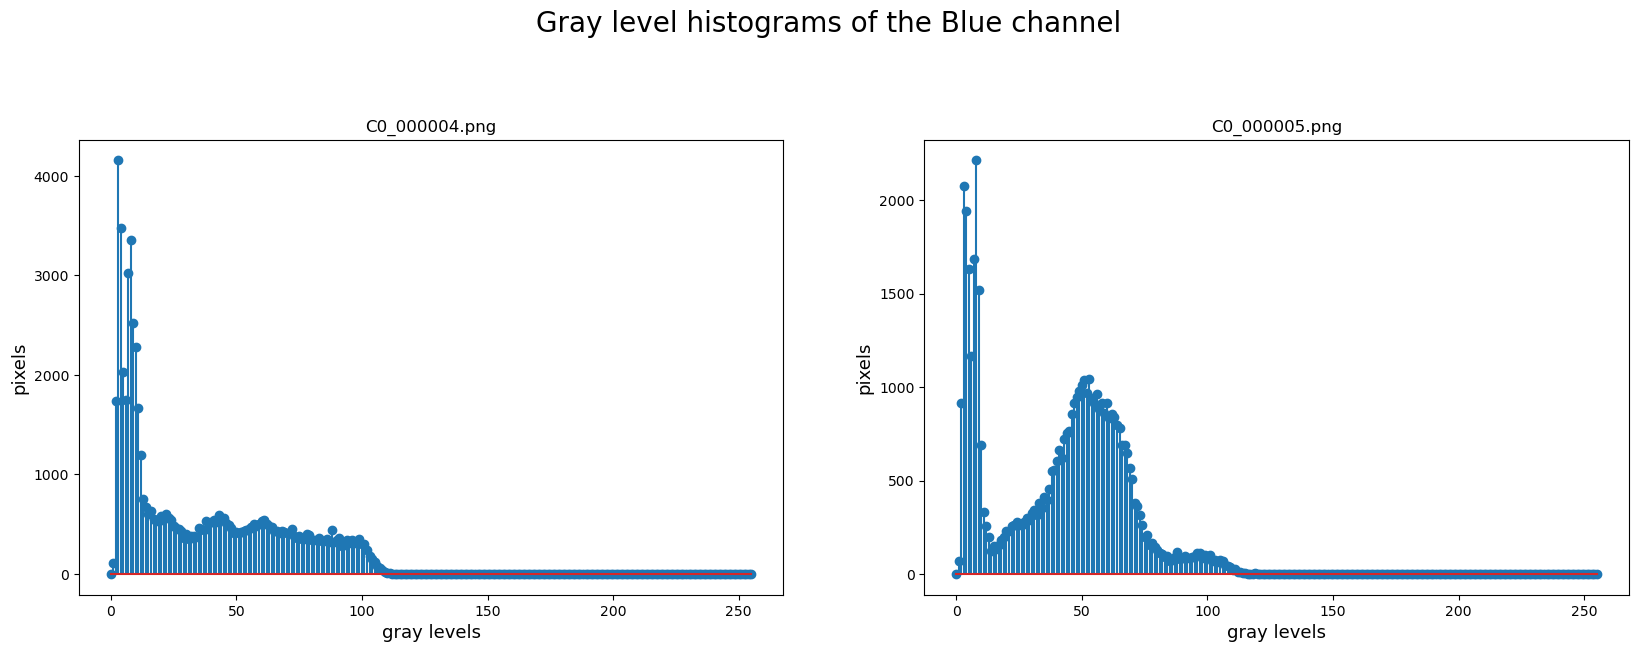

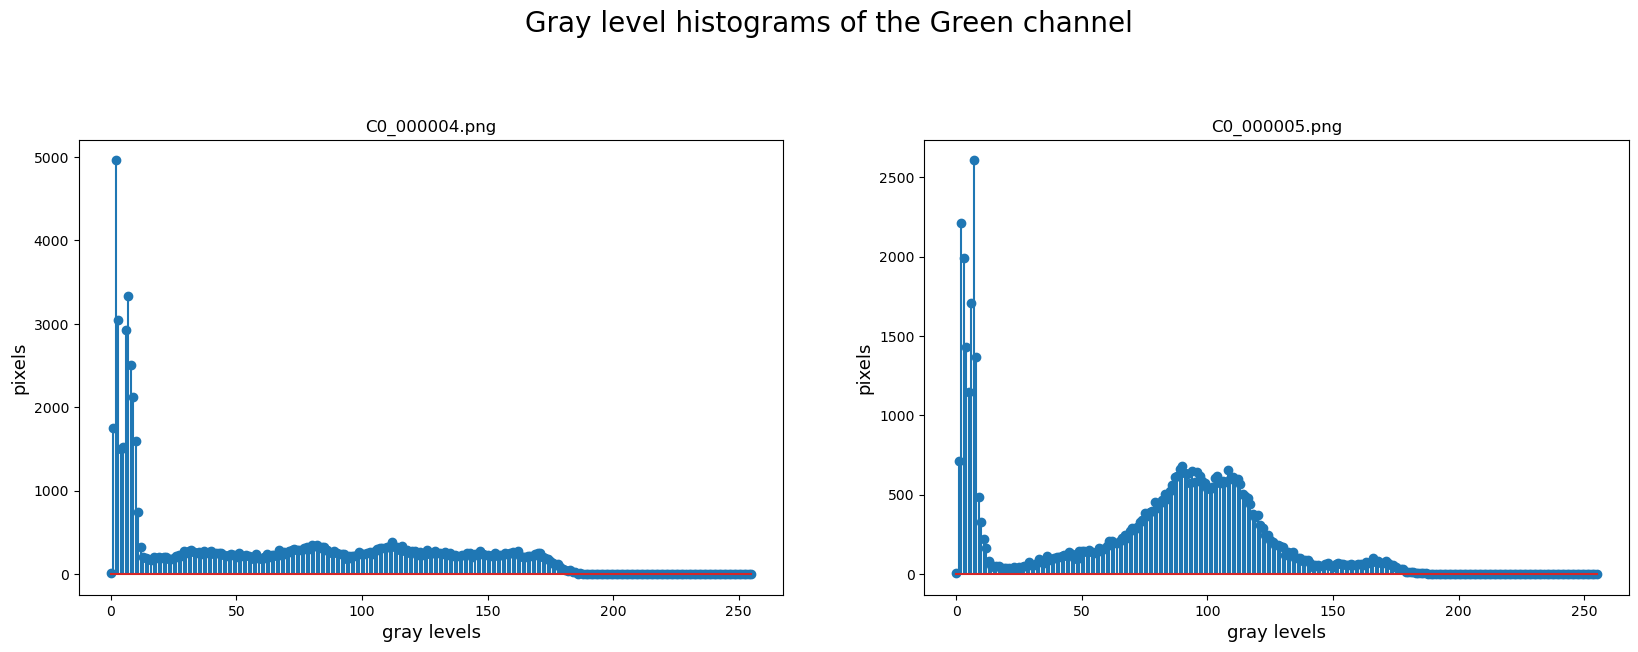

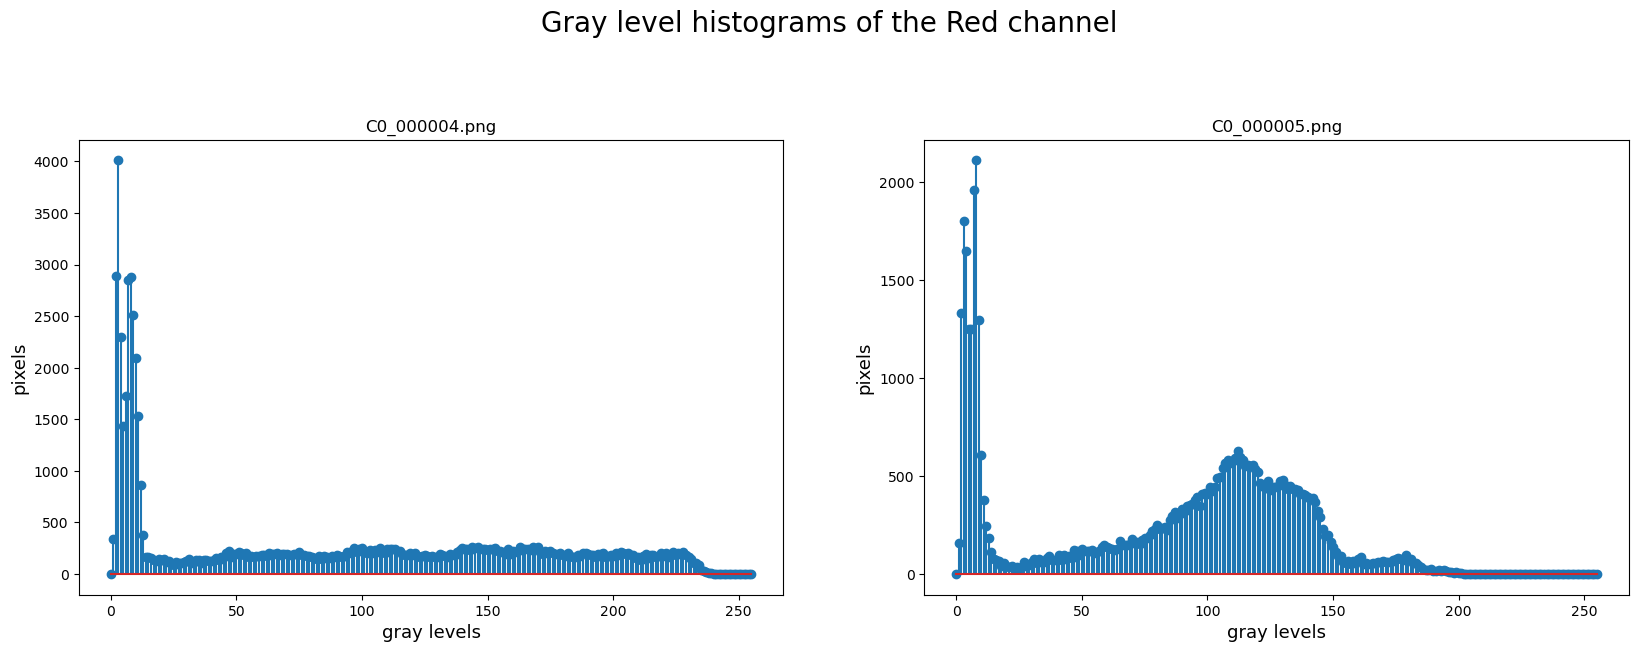

In [7]:
plot_histogram_grid(colour_B, 'Gray level histograms of the Blue channel', nir_names)
plot_histogram_grid(colour_G, 'Gray level histograms of the Green channel', nir_names)
plot_histogram_grid(colour_R, 'Gray level histograms of the Red channel', nir_names)

In [22]:
#equalized_imgs_B = [cv2.equalizeHist(img) for img in colour_B] 

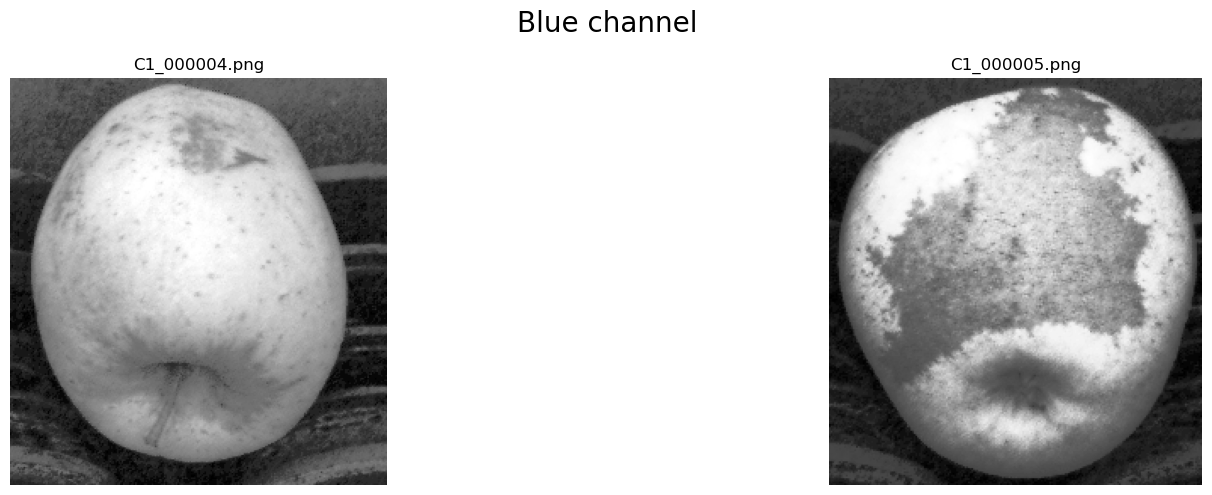

In [23]:
#plot_image_grid(equalized_imgs_B, 'Blue channel', colour_names)

In [26]:
#equalized_imgs_B[0]

array([[103,  99,  99, ..., 103, 103, 103],
       [103,  99,  99, ..., 103,  99,  99],
       [ 99,  99,  99, ...,  99,  99,  99],
       ...,
       [ 36,  43,  36, ...,  43,  36,  36],
       [ 43,  43,  36, ...,  43,  43,  36],
       [ 36,  36,  36, ...,  43,  43,  36]], dtype=uint8)

In [30]:
#equalized_imgs = [cv2.merge([equalized_imgs_B[i], colour_G[i], colour_R[i]]) for i in range(len(colour_imgs))]

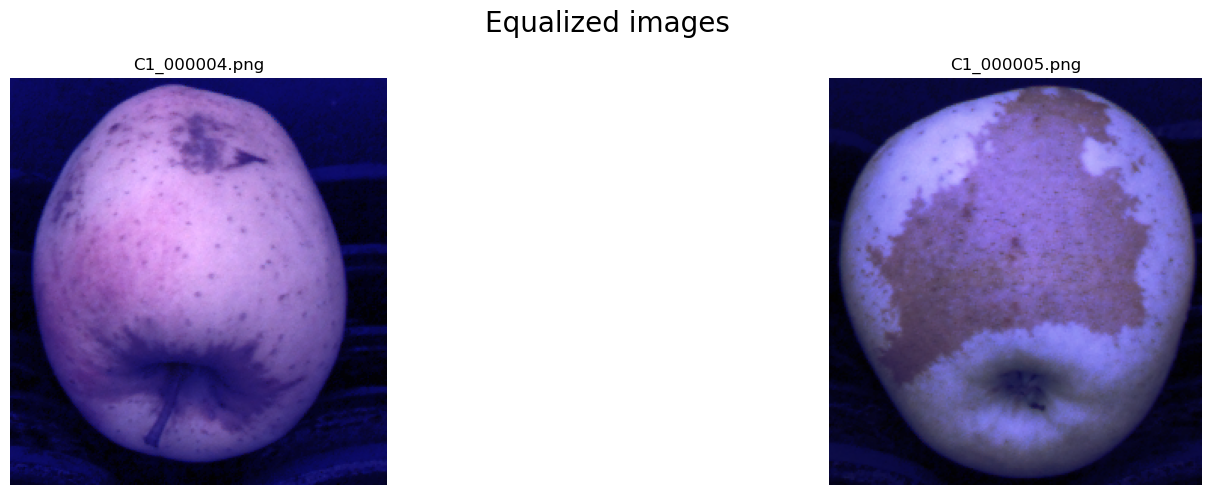

In [31]:
#plot_image_grid(equalized_imgs, 'Equalized images', colour_names)

In [43]:
#SIGMA = 2
#K = math.ceil(3*SIGMA)

#median_filtered_images = [cv2.bilateralFilter(img,11, 100, 75) for img in nir_imgs]
#filtered_colour_images = [cv2.GaussianBlur(img, (2*K+1, 2*K+1), SIGMA) for img in colour_imgs]

In [65]:
filtered_colour_images = [cv2.medianBlur(img,5) for img in colour_imgs]

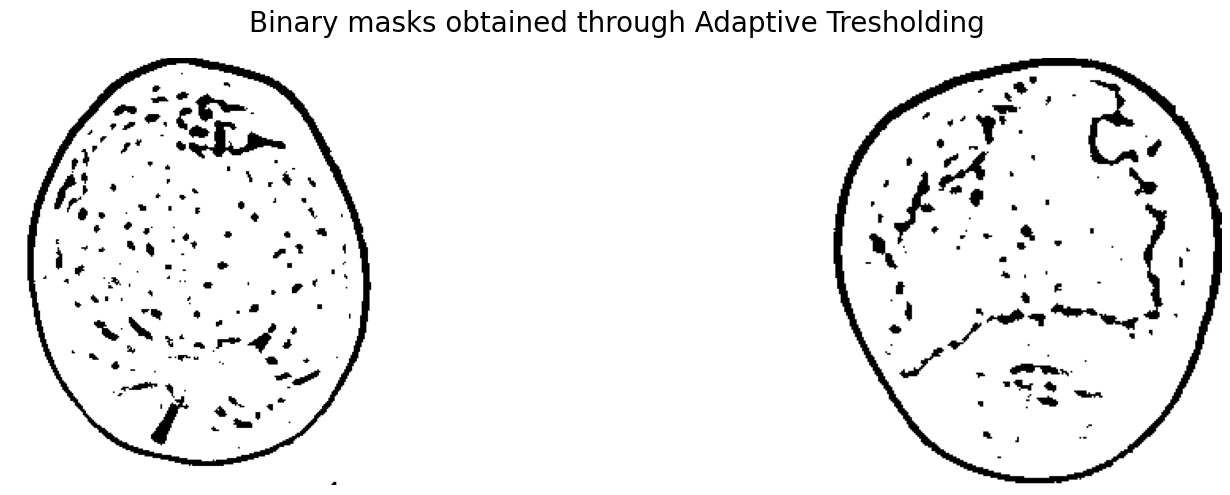

0.234375


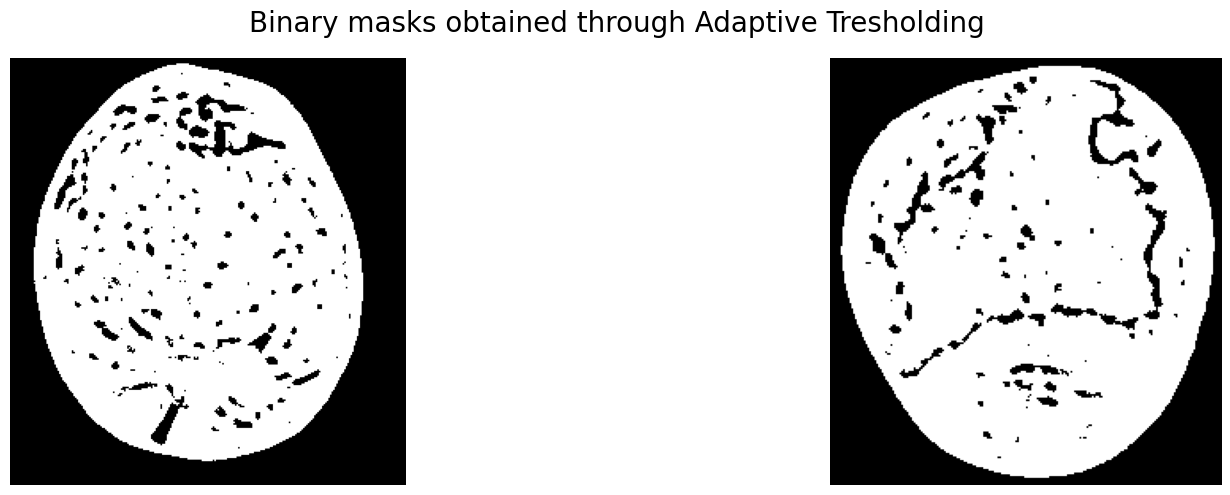

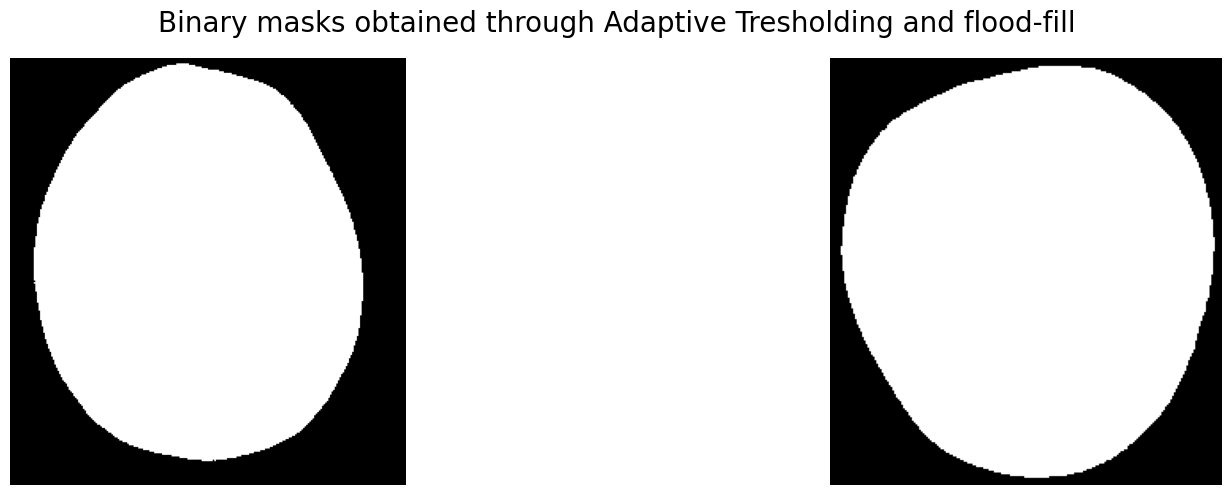

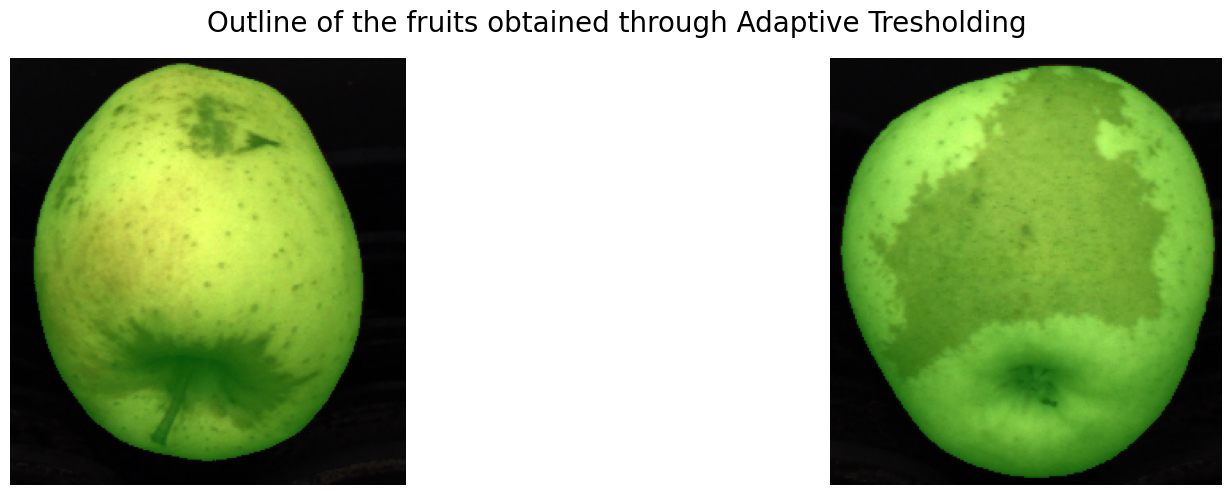

In [66]:
masks = []

s = process_time()
for img in filtered_colour_images:
    mask = cv2.adaptiveThreshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 5)
    masks.append(mask)

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')
    

# Pad masks and flood-fill the background
masks = [np.pad(m, 1, mode='constant', constant_values=255) for m in masks]
for m in masks:
    cv2.floodFill(m, None, (0,0), 0)
# Downsample the masks to their original size
masks = [m[1:-1,1:-1] for m in masks]
print(process_time() - s)

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding and flood-fill')

bounded_images = []

for idx, img in enumerate(colour_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Adaptive Tresholding')

In [67]:
masked_filtered_imgs = [filtered_colour_images[i] & cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks))]

In [74]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.)
flags = cv2.KMEANS_RANDOM_CENTERS

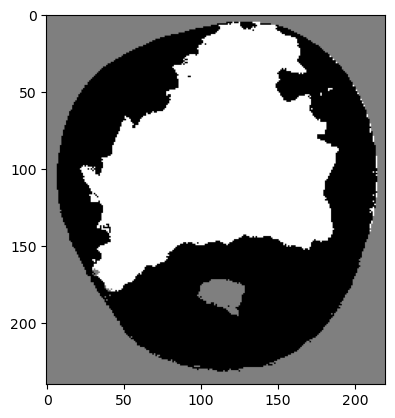

In [75]:
Z = cv2.cvtColor(masked_filtered_imgs[1], cv2.COLOR_BGR2LAB)
Z = Z[:,:,1:]
Z = Z.reshape(-1,2)
Z = np.float32(Z)

compactness_1, labels_1, center_1 = cv2.kmeans(Z, 3, None, criteria, 100, flags)

labels_1[labels_1 == 1] = 255 // 2
labels_1[labels_1 == 2] = 255
res_1 = labels_1.reshape(masked_filtered_imgs[1].shape[0], masked_filtered_imgs[1].shape[1])


'''print(center_1)
print(np.unique(labels_1))

center_1 = np.uint8(center_1)
res_1 = center_1[labels_1]
res_1 = res_1.reshape(masked_filtered_imgs[1].shape[0], masked_filtered_imgs[1].shape[1], 2)[:,:,0]'''

plt.imshow(res_1, cmap='gray', vmin=0, vmax=255)

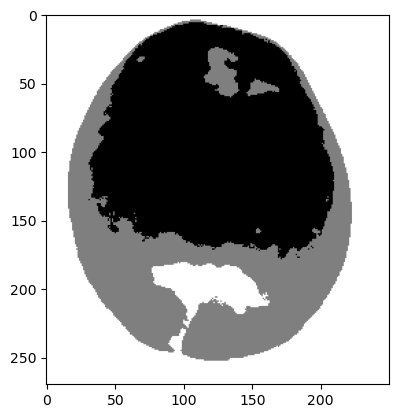

In [76]:
Z = cv2.cvtColor(masked_filtered_imgs[0], cv2.COLOR_BGR2LAB)
Z = Z[:,:,1:]
Z = Z.reshape(-1,2)
Z = np.float32(Z)

compactness_1, labels_1, center_1 = cv2.kmeans(Z, 3, None, criteria, 100, flags)

labels_1[labels_1 == 1] = 255 // 2
labels_1[labels_1 == 2] = 255
res_1 = labels_1.reshape(masked_filtered_imgs[0].shape[0], masked_filtered_imgs[0].shape[1])

plt.imshow(res_1, cmap='gray', vmin=0, vmax=255)

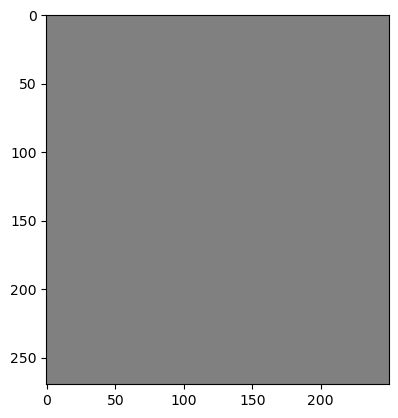

In [51]:
'''Z = cv2.cvtColor(masked_filtered_imgs[0], cv2.COLOR_BGR2LAB)
Z = Z[:,:,1:]
Z = Z.reshape(-1,2)
Z = np.float32(Z)

compactness, label, center = cv2.kmeans(Z, 3, None, criteria, 100, flags)

center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape(masked_filtered_imgs[0].shape[0], masked_filtered_imgs[0].shape[1], 2)

plt.imshow(cv2.cvtColor(res2[:,:,0], cv2.COLOR_GRAY2RGB))''';

In [22]:
'''reshaped_imgs = [np.copy(img) for img in filtered_colour_images]
reshaped_imgs[0] = reshaped_imgs[0][:reshaped_imgs[1].shape[0], :reshaped_imgs[1].shape[1], :]

reshaped_imgs = [img.reshape((-1, 3)) for img in reshaped_imgs]
for i in reshaped_imgs:
    print(i.shape)
kmeans = KMeans(n_clusters=3, random_state=0).fit(reshaped_imgs[1])

labels = kmeans.predict(reshaped_imgs[1])'''

(52800, 3)
(52800, 3)


In [71]:
'''labels = [0 if i == 1 else 100 if i == 2 else 255 for i in labels]'''

'labels = [0 if i == 1 else 100 if i == 2 else 255 for i in labels]'

In [72]:
'''plt.imshow(np.array(labels).reshape(filtered_colour_images[1].shape[0], filtered_colour_images[1].shape[1]), cmap='gray', vmin=0, vmax=255)'''

"plt.imshow(np.array(labels).reshape(filtered_colour_images[1].shape[0], filtered_colour_images[1].shape[1]), cmap='gray', vmin=0, vmax=255)"

In [37]:
# Create HSV, HLS, LUV images
colour_space_dict = {
    'BGR': colour_imgs,
    'HSV': [cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL) for img in filtered_colour_images],
    'HLS': [cv2.cvtColor(img, cv2.COLOR_BGR2HLS_FULL) for img in filtered_colour_images],
    'LUV': [cv2.cvtColor(img, cv2.COLOR_BGR2Luv) for img in filtered_colour_images],
    'LAB': [cv2.cvtColor(img, cv2.COLOR_BGR2LAB) for img in filtered_colour_images],
    'YCrCb': [cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb) for img in filtered_colour_images],
    'YUV': [cv2.cvtColor(img, cv2.COLOR_BGR2YUV) for img in filtered_colour_images]
}
'''
print(hsv_imgs[0].shape)
print(hls_imgs[0].shape)
print(luv_imgs[0].shape)
print(lab_imgs[0].shape)
print(ycrcb_imgs[0].shape)
print(yuv_imgs[0].shape)''';

In [9]:
def show_split_channels(imgs, colour_space_name, imgs_names=None):
    assert imgs_names is None or len(imgs_names) == len(imgs), \
        '`images_names` must not be provided or it must have the same size as `images`.'
    
    channel_1 = []; channel_2 = []; channel_3 = []

    for img in imgs:
        ch1, ch2, ch3 = cv2.split(img)
        channel_1.append(ch1)
        channel_2.append(ch2)
        channel_3.append(ch3)

    colour_space_name = f'({colour_space_name})'
    # Plot the Channels of the images
    plot_image_grid(channel_1, f'First channel {colour_space_name}', imgs_names)
    plot_image_grid(channel_2, f'Second channel {colour_space_name}', imgs_names)
    plot_image_grid(channel_3, f'Third channel {colour_space_name}', imgs_names)

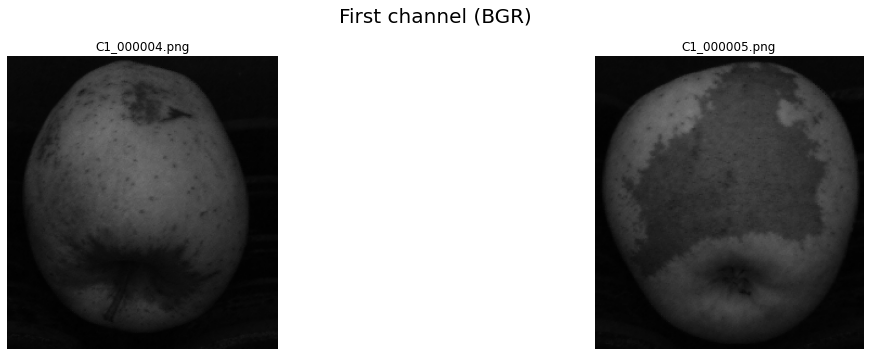

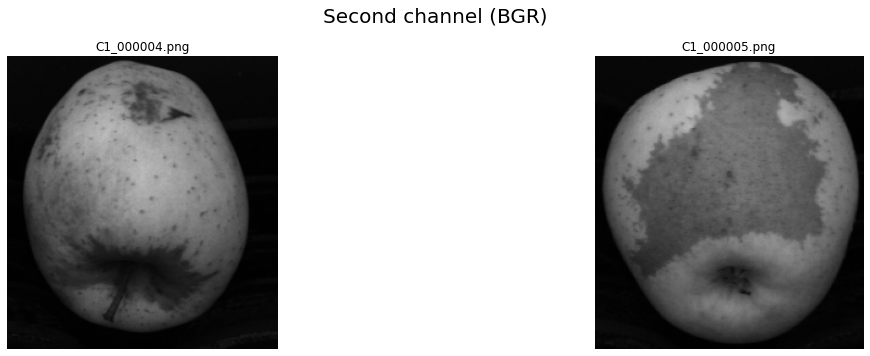

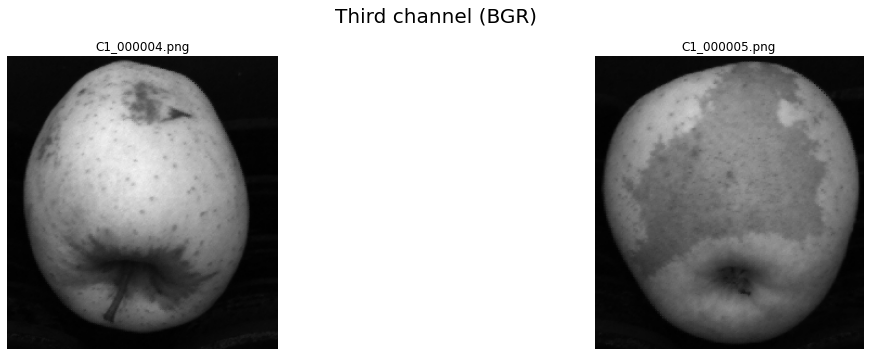

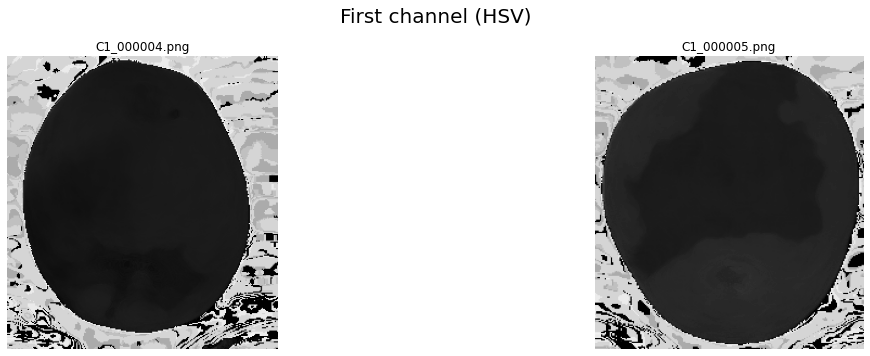

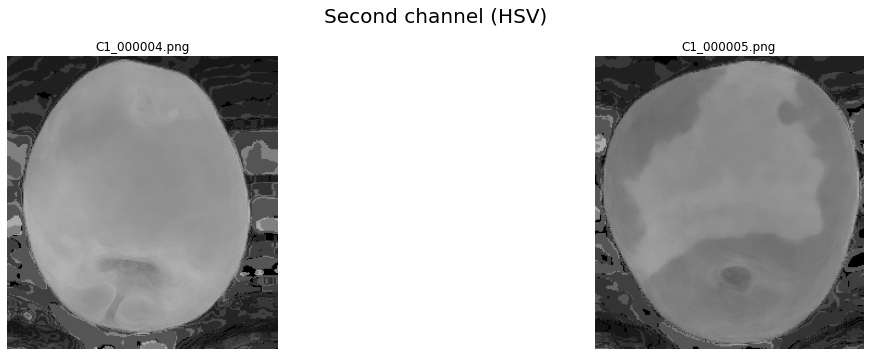

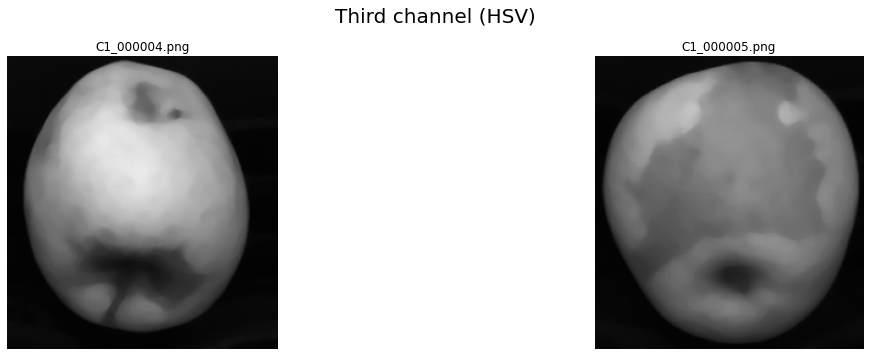

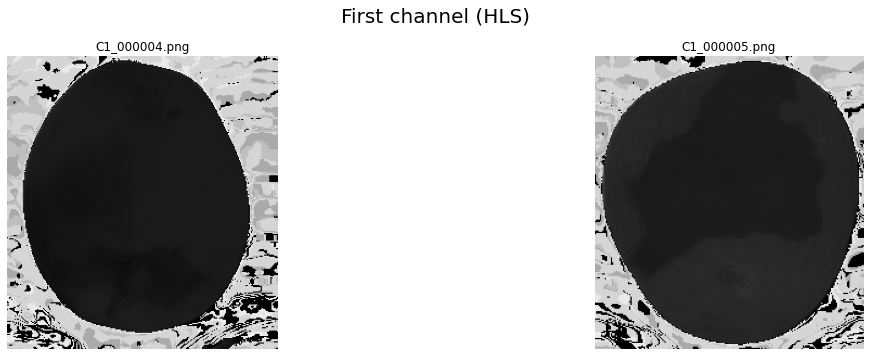

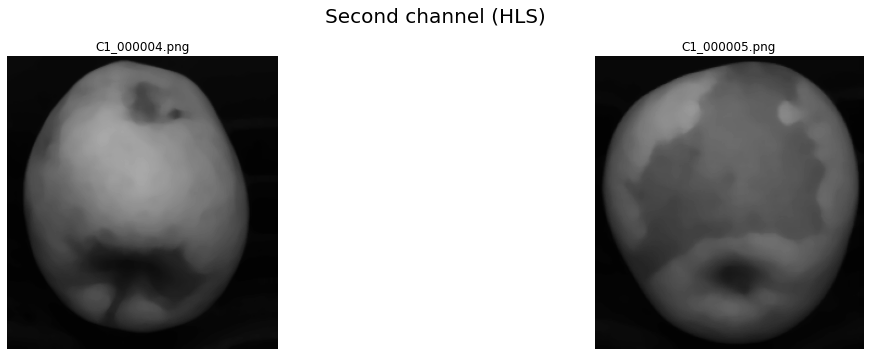

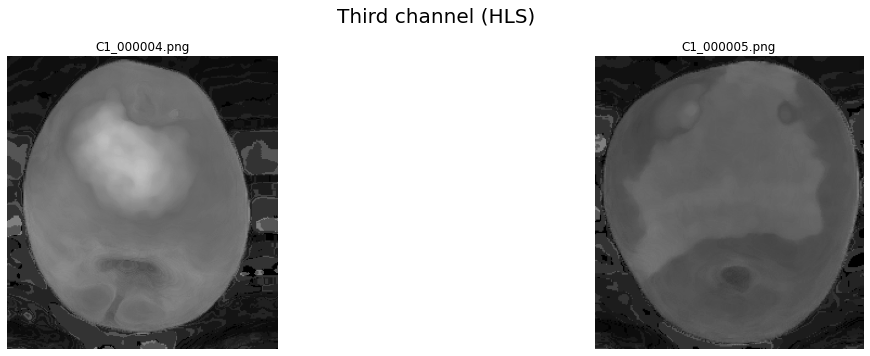

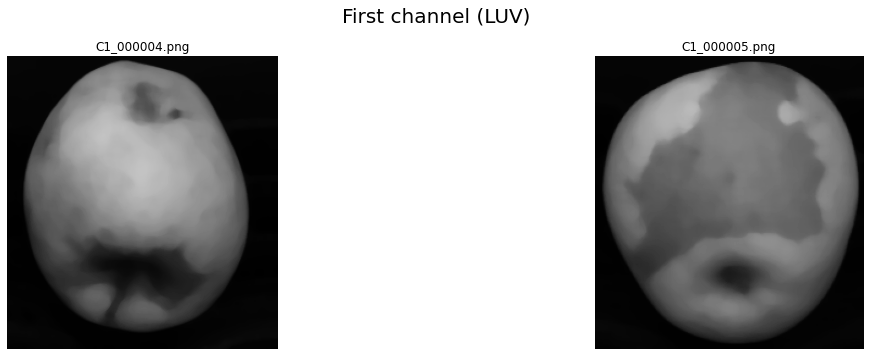

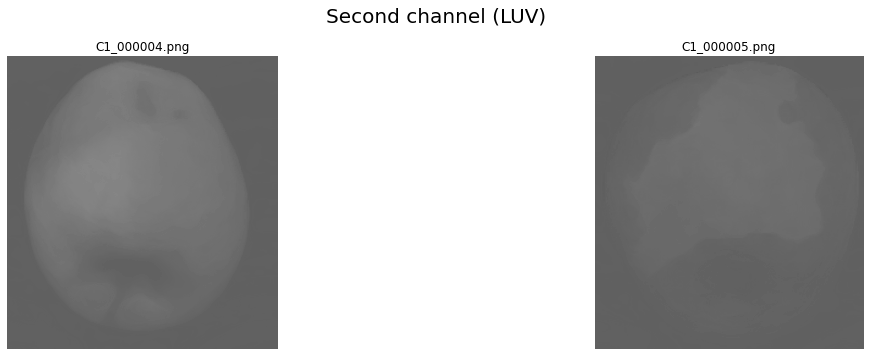

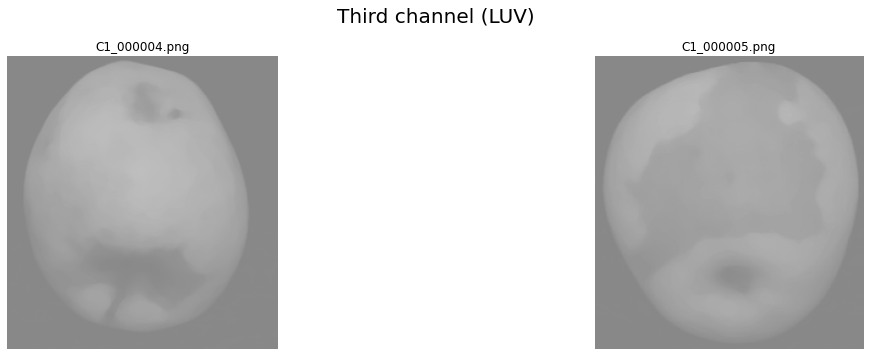

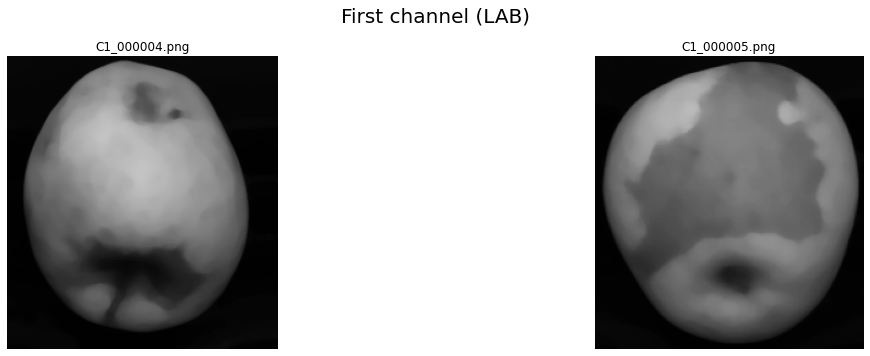

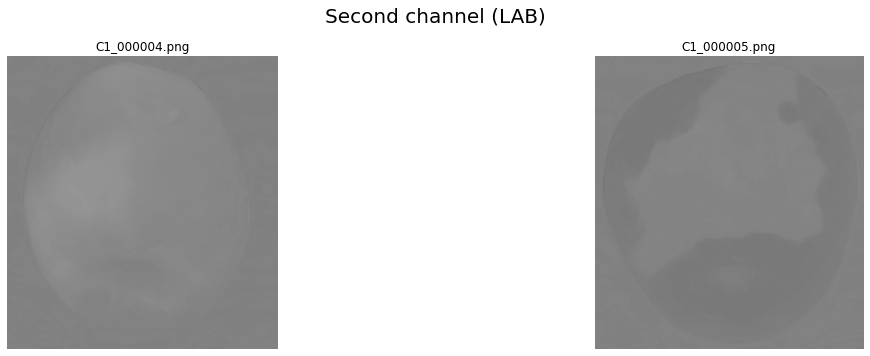

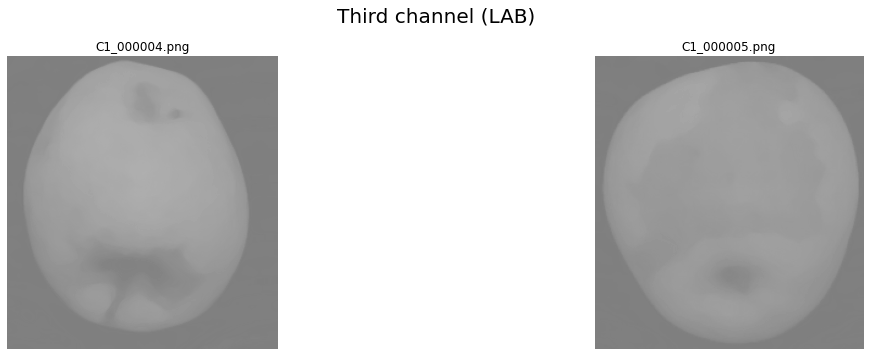

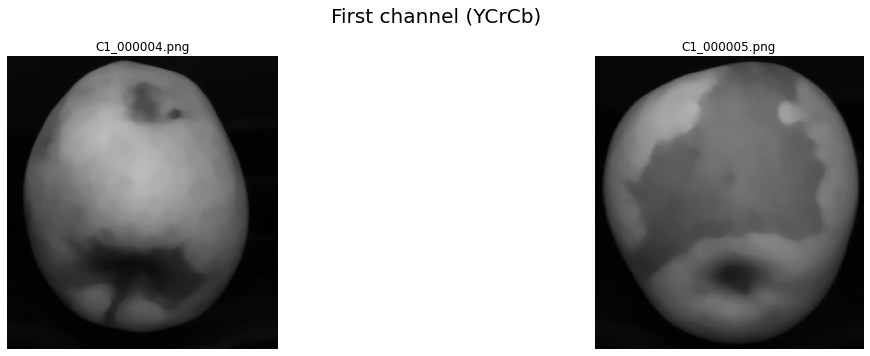

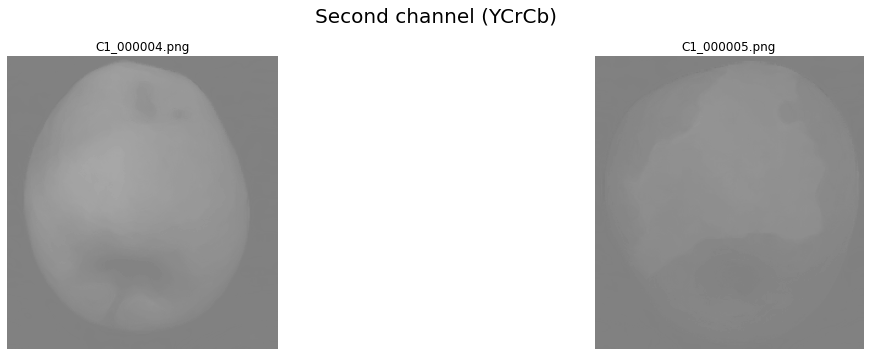

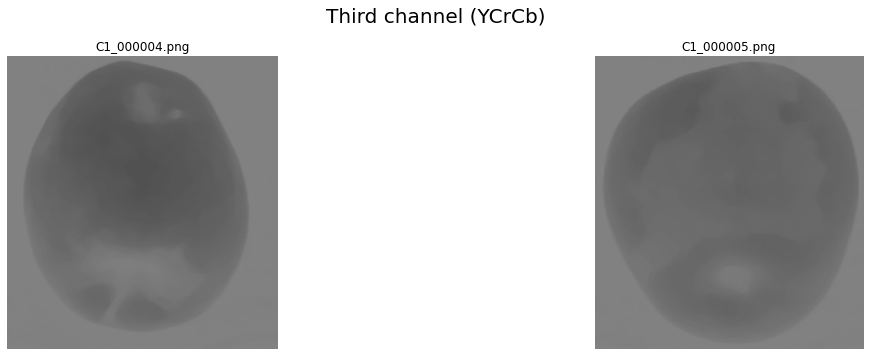

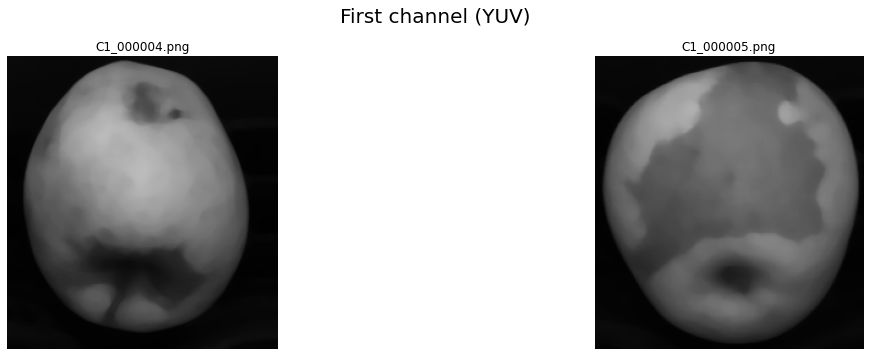

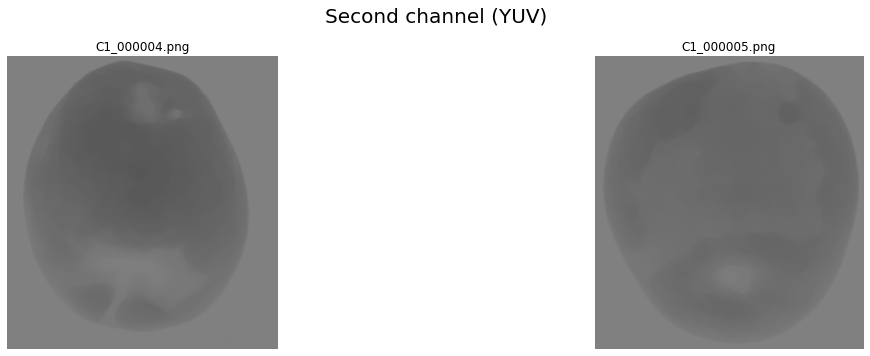

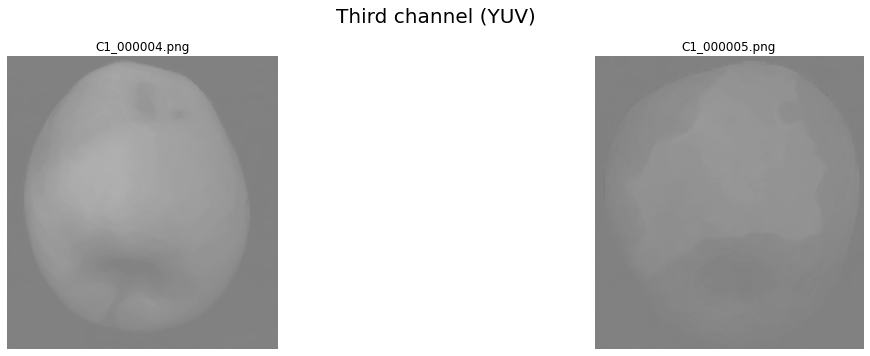

In [10]:
for k in colour_space_dict:
    show_split_channels(colour_space_dict[k], k, imgs_names=colour_names)

In [11]:
# plot_histogram_grid(colour_B, 'Gray level histograms of the Blue channel', nir_names)
# plot_histogram_grid(colour_G, 'Gray level histograms of the Green channel', nir_names)
# plot_histogram_grid(colour_R, 'Gray level histograms of the Red channel', nir_names)

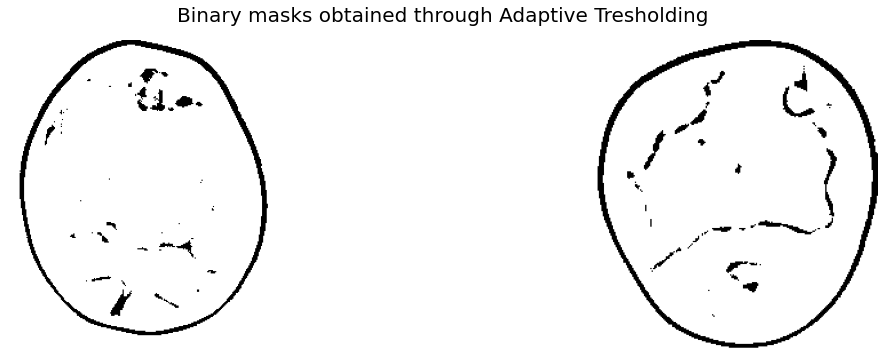

0.109375


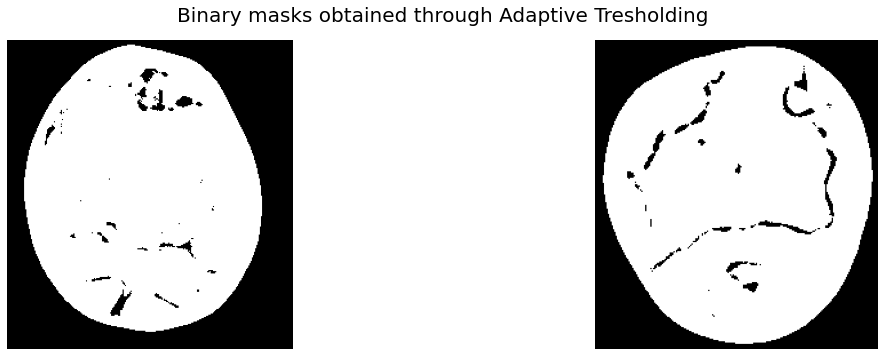

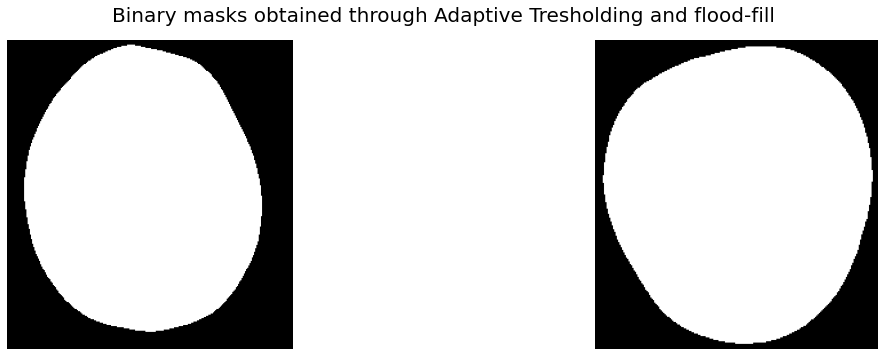

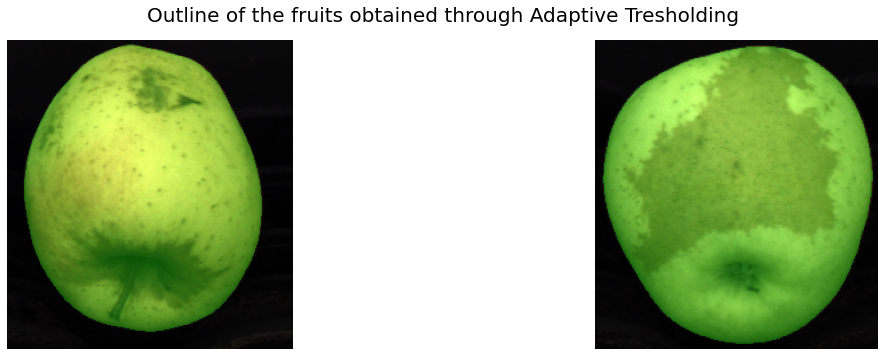

In [12]:
masks = []

s = process_time()
for img in filtered_colour_images:
    mask = cv2.adaptiveThreshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 5)
    masks.append(mask)

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')
    

# Pad masks and flood-fill the background
masks = [np.pad(m, 1, mode='constant', constant_values=255) for m in masks]
for m in masks:
    cv2.floodFill(m, None, (0,0), 0)
# Downsample the masks to their original size
masks = [m[1:-1,1:-1] for m in masks]
print(process_time() - s)

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding and flood-fill')

bounded_images = []

for idx, img in enumerate(colour_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Adaptive Tresholding')

In [14]:
masked_nir_imgs = [nir_imgs[i] & masks[i] for i in range(len(masks))]


masked_filtered_imgs = [filtered_colour_images[i] & cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks))]


masked_colour_imgs = [colour_imgs[i] &  cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks))]

In [42]:
covariance_tot = np.zeros((2, 2), dtype='float32')
mean_tot = np.zeros((2,), dtype='float32')

# Iterate over samples to compute the reference color (i.e. mean of samples) and its total covariance
for s in masked_filtered_imgs:
    s_ab = cv2.cvtColor(s, cv2.COLOR_BGR2LAB)[:, :, 1:3]
    print(s_ab.shape)
    s_ab_r = s_ab.reshape(s_ab.shape[0] * s_ab.shape[1], 2)
    print(s_ab_r.shape)
    cov, mean = cv2.calcCovarMatrix(s_ab_r, None, cv2.COVAR_NORMAL + cv2.COVAR_ROWS + cv2.COVAR_SCALE)
    covariance_tot = np.add(covariance_tot, cov)
    mean_tot = np.add(mean_tot, mean)
    
mean_tot = mean_tot / len(masked_filtered_imgs)

(270, 250, 2)
(67500, 2)
(240, 220, 2)
(52800, 2)


In [43]:
inv_covariance_matrix = np.linalg.inv(covariance_tot)

In [50]:
img = masked_filtered_imgs[0]
img_flattened = img.reshape(img.shape[0] * img.shape[1], 3)
img_flattened = img_flattened.astype(np.float64)

print(mean_tot.shape)

img_res = [
    cv2.Mahalanobis(i, mean_tot[-1], inv_covariance_matrix) if i[0] != 0 and i[1] != 0 else 200  
    for i in img_flattened[:,1:]
]
img_res = np.array(img_res)
#print(img_flattened[0].shape) 
#print(mean_tot.shape)

#cv2.Mahalanobis(img_flattened[0], mean_tot[-1], inv_covariance_matrix)



'''f = lambda v1: cv2.Mahalanobis(v1, mean_tot, inv_covariance_matrix)
f_arr = np.frompyfunc(f, 1, 1)

res_img = f_arr(img_flattened)''';

#cv2.Mahalanobis(v1, v2, inv_covariance_matrix)

(1, 2)


In [51]:
print(img_res.shape)

(67500,)


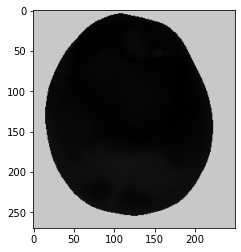

In [52]:
img_res = img_res.reshape((img.shape[0], img.shape[1]))
# print(img_res)
img_tresh = np.copy(img_res)

# img_tresh[img_tresh > 23] = 0

plt.imshow(img_tresh, cmap='gray', vmin=0, vmax=255)

In [37]:
img = masked_filtered_imgs[1]

In [38]:
s = img
s_ab = cv2.cvtColor(s, cv2.COLOR_BGR2LAB)[:, :, 1:3]
s_ab_r = s_ab.reshape(s_ab.shape[0] * s_ab.shape[1], 2)
cov, mean = cv2.calcCovarMatrix(s_ab_r, None, cv2.COVAR_NORMAL + cv2.COVAR_ROWS + cv2.COVAR_SCALE)
covariance_tot = cov
mean_tot = mean

print(covariance_tot)
print(mean_tot)

[[ 15.24401945  -3.66947409]
 [ -3.66947409 158.98258554]]
[[127.37433712 146.67909091]]


In [39]:
img_flattened = img.reshape(img.shape[0] * img.shape[1], 3)
img_flattened = img_flattened.astype(np.float64)

print(mean_tot.shape)

img_res = [cv2.Mahalanobis(i, mean_tot[-1], inv_covariance_matrix) for i in img_flattened[:,1:3]]
img_res = np.array(img_res)


(1, 2)


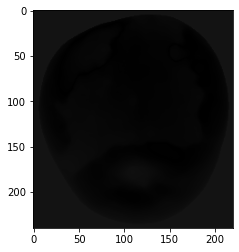

In [40]:
img_res = img_res.reshape((img.shape[0], img.shape[1]))
# print(img_res)
img_tresh = np.copy(img_res)

# img_tresh[img_tresh > 23] = 0

plt.imshow(img_tresh, cmap='gray', vmin=0, vmax=255)